The second change Audacity wants to try is on their course overview page. They created a new description for one of their courses to dedicate larger portions to connecting concepts in the course to career skills, and less on the details of each concept. They hope that this change may encourage more users to complete the course. For this experiment, instead of choosing just a single metric, we're going to analyze multiple. We'll track the enrolment rate, the average reading time on the course page, the average time spent in the classroom, and the course completion rate. First, we'll analyze these individually and then, we'll see how they all come together.

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

np.random.seed(42)

In [72]:
df = pd.read_csv('course_page_actions.csv')
df.head()

,timestamp,id,group,action,duration
0,2016-09-24 17:14:52.012145,261869,experiment,view,130.545004
1,2016-09-24 18:45:09.645857,226546,experiment,view,159.862440
2,2016-09-24 19:16:21.002533,286353,experiment,view,79.349315
3,2016-09-24 19:43:06.927785,842279,experiment,view,55.536126
4,2016-09-24 21:08:22.790333,781883,experiment,view,204.322437


In [73]:
# Get dataframe with all records from control group
control_df = df.query('group == "control"')

# Compute click through rate for control group
control_ctr = control_df.query('action == "enroll"').count()[0] / control_df.query('action == "view"').count()[0]

# Display click through rate
control_ctr

0.23452157598499063

In [74]:
# Get dataframe with all records from experiment group
experiment_df = df.query('group == "experiment"')

# Compute click through rate for experiment group
experiment_ctr = experiment_df.query('action == "enroll"').count()[0] / experiment_df.query('action == "view"').count()[0]

# Display click through rate
experiment_ctr

0.2642986152919928

In [75]:
# Compute the observed difference in click through rates
obs_diff = experiment_ctr - control_ctr

# Display observed difference
obs_diff

0.02977703930700215

In [76]:
# Create a sampling distribution of the difference in proportions
# with bootstrapping
diffs = []
size = df.shape[0]
for _ in range(10000):
    b_samp = df.sample(size, replace=True)
    control_df = b_samp.query('group == "control"')
    experiment_df = b_samp.query('group == "experiment"')
    control_ctr = control_df.query('action == "enroll"').count()[0] / control_df.query('action == "view"').count()[0]
    experiment_ctr = experiment_df.query('action == "enroll"').count()[0] / experiment_df.query('action == "view"').count()[0]
    diffs.append(experiment_ctr - control_ctr)

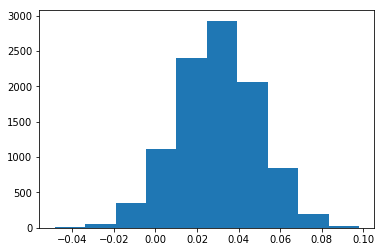

In [77]:
# Convert to numpy array
diffs = np.array(diffs)

# Plot sampling distribution
plt.hist(diffs);

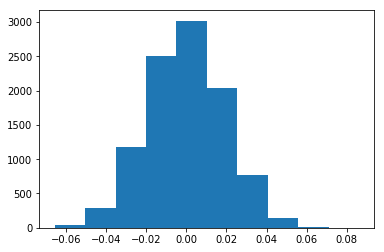

In [78]:
# Simulate distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)

# Plot the null distribution
plt.hist(null_vals);

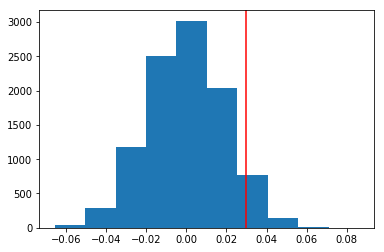

In [79]:
# Plot observed statistic with the null distibution
plt.hist(null_vals)
plt.axvline(x=obs_diff, color='red');

In [80]:
# Compute p-value
(null_vals > obs_diff).mean()

0.0624

Hence, we do not have evidence that with a type I error rate of 0.05, the enrollment rate for this course increases when using the experimental description on its overview page.

In addition to computing the enrolment rate, we can also compute the average reading durations with this dataset. The two analysis so far were comparing proportions. With this metric, we'll be analyzing the differnce in means. This analysis will be quite similar. Since we're comparing reading durations, we only care about view action. So let's filter by that first.

In [81]:
df = pd.read_csv('course_page_actions.csv')
df.head(10)

,timestamp,id,group,action,duration
0,2016-09-24 17:14:52.012145,261869,experiment,view,130.545004
1,2016-09-24 18:45:09.645857,226546,experiment,view,159.862440
2,2016-09-24 19:16:21.002533,286353,experiment,view,79.349315
3,2016-09-24 19:43:06.927785,842279,experiment,view,55.536126
4,2016-09-24 21:08:22.790333,781883,experiment,view,204.322437
5,2016-09-24 17:14:52.012145,261869,experiment,view,130.545004
6,2016-09-24 18:45:09.645857,226546,experiment,view,159.862440
7,2016-09-24 19:16:21.002533,286353,experiment,view,79.349315
8,2016-09-24 19:43:06.927785,842279,experiment,view,55.536126
9,2016-09-24 21:08:22.790333,781883,experiment,enroll,204.322437


In [82]:
views = df.query('action == "view"')

And let's only count each unique user once by finding their average reading duration if they visited the site more than once. We'll also group by group, just so we keep track of that information. Resetting the index just so we keep the ID and group as column names. And it also let's us continue working in a data frame instead of a multi index series.

In [83]:
reading_times = views.groupby(['id', 'group'])['duration'].mean()

In [84]:
reading_times = reading_times.reset_index()

In [85]:
reading_times.head()

,id,group,duration
0,183260,control,107.331484
1,183615,experiment,24.627594
2,184277,experiment,193.212489
3,184360,experiment,226.586283
4,184589,experiment,12.052097


In [86]:
control_mean = df.query('group == "control"')['duration'].mean()
experiment_mean = df.query('group == "experiment"')['duration'].mean()
control_mean, experiment_mean

(115.40710650582038, 130.93220512539477)

In [87]:
obs_diff = experiment_mean - control_mean
obs_diff

15.525098619574393

On average, it looks like users in the experiment group spent 15 more seconds on the course overview page than those in the control group. To see if this difference is significant, let's simulate the sampling distribution for the difference in mean reading durations with bootstrapping.

In [88]:
diffs = []
for _ in range(10000):
    b_samp = df.sample(df.shape[0], replace=True)
    control_mean = b_samp.query('group == "control"')['duration'].mean()
    experiment_mean = b_samp.query('group == "experiment"')['duration'].mean()
    diffs.append(experiment_mean - control_mean)

In [89]:
diffs = np.array(diffs)

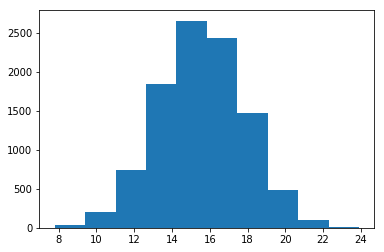

In [90]:
plt.hist(diffs);

Now, to find the p-value let's simulate the distribution under the null and find the probability that our observed statistic came from this distribution. We'll create the distribution centered at 0 and having the same spread as our sampling distribution.

In [91]:
null_vals = np.random.normal(0, diffs.std(), diffs.size)

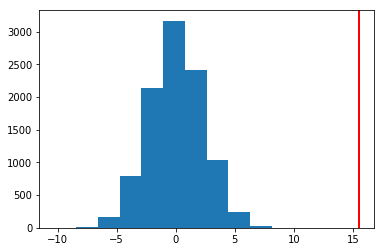

In [92]:
plt.hist(null_vals)
plt.axvline(x=obs_diff, color='r', linewidth=2);

Looking at our null distribution and where our observed statistic falls, we can say that our statistic definitely doesn't look like it came from this null distribution. Looks like the difference we observed is significant.

Again, let's recap the steps we took to analyze the results of this A/B test.

- We computed the observed difference between the metric, average reading duration, for the control and experiment group.
- We simulated the sampling distribution for the difference in means (or average reading durations).
- We used this sampling distribution to simulate the distribution under the null hypothesis, by creating a random normal distribution centered at 0 with the same spread and size.
- We computed the p-value by finding the proportion of values in the null distribution that were greater than our observed difference.
- We used this p-value to determine the statistical significance of our observed difference.

In [93]:
df = pd.read_csv('classroom_actions.csv')
df.head(10)

,timestamp,id,group,total_days,completed
0,2015-08-10 17:06:01.032740,610019,experiment,97,True
1,2015-08-10 17:15:28.950975,690224,control,75,False
2,2015-08-10 17:34:40.920384,564994,experiment,128,True
3,2015-08-10 17:50:39.847374,849588,experiment,66,False
4,2015-08-10 19:10:40.650599,849826,experiment,34,False
5,2015-08-10 19:58:07.004051,763661,control,55,False
6,2015-08-10 20:10:42.230941,634832,control,97,False
7,2015-08-10 20:29:33.099757,849686,control,97,False
8,2015-08-10 21:03:33.719529,929620,experiment,90,False
9,2015-08-10 22:47:00.254898,512761,experiment,59,False


In [94]:
# The total_days represents the total amount of time
# each student has spent in classroom.
# get the average classroom time for control group
control_mean = df.query('group == "control"')['total_days'].mean()

# get the average classroom time for experiment group
experiment_mean = df.query('group == "experiment"')['total_days'].mean()

# display average classroom time for each group
control_mean, experiment_mean

(73.36899038461539, 74.6715935334873)

In [95]:
# compute observed difference in classroom time
obs_diff = experiment_mean - control_mean

# display observed difference
obs_diff

1.3026031488719099

In [96]:
# create sampling distribution of difference in average classroom times
# with boostrapping
diffs = []
for _ in range(10000):
    boot_sample = df.sample(df.shape[0], replace=True)
    control_mean = boot_sample.query('group == "control"')['total_days'].mean()
    experiment_mean = boot_sample.query('group == "experiment"')['total_days'].mean()
    diffs.append(experiment_mean - control_mean)

In [97]:
# convert to numpy array
diffs = np.array(diffs)

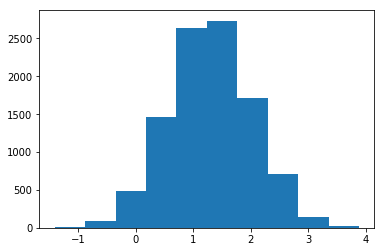

In [98]:
# plot sampling distribution
plt.hist(diffs);

In [99]:
# simulate distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)

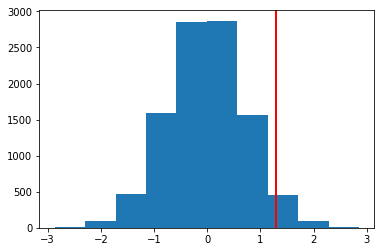

In [100]:
# plot null distribution
plt.hist(null_vals)

# plot line for observed statistic
plt.axvline(x=obs_diff, color='r', linewidth=2);

In [101]:
# compute p value
(null_vals > obs_diff).mean()

0.0387

Hence, we do have evidence that with a type I error rate of 0.05, users spent more time in the classroom after seeing the experimental description in the course overview page. But this difference is practically insignificant.

In [102]:
df = pd.read_csv('classroom_actions.csv')
df.head(10)

,timestamp,id,group,total_days,completed
0,2015-08-10 17:06:01.032740,610019,experiment,97,True
1,2015-08-10 17:15:28.950975,690224,control,75,False
2,2015-08-10 17:34:40.920384,564994,experiment,128,True
3,2015-08-10 17:50:39.847374,849588,experiment,66,False
4,2015-08-10 19:10:40.650599,849826,experiment,34,False
5,2015-08-10 19:58:07.004051,763661,control,55,False
6,2015-08-10 20:10:42.230941,634832,control,97,False
7,2015-08-10 20:29:33.099757,849686,control,97,False
8,2015-08-10 21:03:33.719529,929620,experiment,90,False
9,2015-08-10 22:47:00.254898,512761,experiment,59,False


In [103]:
# Create dataframe with all control records
control_df = df.query('group == "control"')

# Compute completion rate
control_ctr = control_df.query('completed == True').count()[0] / control_df.shape[0]

# Display completion rate
control_ctr

0.3719951923076923

In [104]:
# Create dataframe with all experiment records
experiment_df = df.query('group == "experiment"')

# Compute completion rate
experiment_ctr = experiment_df.query('completed == True').count()[0] / experiment_df.shape[0]

# Display completion rate
experiment_ctr

0.3935334872979215

In [105]:
# Compute observed difference in completion rates
obs_diff = experiment_ctr - control_ctr

# Display observed difference in completion rates
obs_diff

0.02153829499022919

In [106]:
# Create sampling distribution for difference in completion rates
# with boostrapping
diffs = []
for _ in range(10000):
    boot_sample = df.sample(df.shape[0], replace=True)
    control_df = boot_sample.query('group == "control"')
    experiment_df = boot_sample.query('group == "experiment"')
    control_ctr = control_df.query('completed == True').count()[0] / control_df.shape[0]
    experiment_ctr = experiment_df.query('completed == True').count()[0] / experiment_df.shape[0]
    diffs.append(experiment_ctr - control_ctr)

In [107]:
# convert to numpy array
diffs = np.array(diffs)

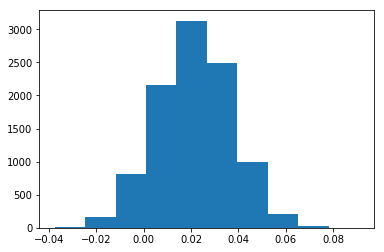

In [108]:
# plot distribution
plt.hist(diffs);

In [109]:
# create distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)

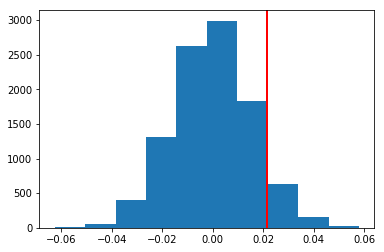

In [110]:
# plot null distribution
plt.hist(null_vals)

# plot line for observed statistic
plt.axvline(x=obs_diff, color='r', linewidth=2);

In [111]:
# compute p value
(null_vals > obs_diff).mean()

0.082

Hence, we do not have evidence that with a type I error rate of 0.05, this course increases in completion rate when using the experimental description on its course overview page.

The more things that you test, the more likely you are to observe significant differences just by chance. This happens when we run evaluations from multiple metrics metrics at the same time. The probability of any false positive increases as you increase the number of metrics. Luckily, this is something we can fix. The Bonferroni Correction is one way we could handle experiments with multiple tests, or metrics in this case. To compute the new bonferroni correct alpha value, we need to divide the original alpha value by the number of tests. If our original alpha value was 0.05, our new Bonferroni corrected alpha value is 0.05/4 = 0.0125

What results are still statistically significant?
Let's see which of our metrics produced statistically significant differences based on this new alpha value. Here are the p-values computed for the four metrics in this experiment. (These are the values you should've gotten with a random seed of 42.)

- Enrollment Rate: 0.0624
- Average Reading Duration: 0
- Average Classroom Time: 0.0384
- Completion Rate: 0.0846

With the Bonferroni corrected alpha value, "Average Reading Duration" produced statistically significant results.

How do we make a recommendation when 3 out of our 4 metrics had a significant difference for testing each metric individually, but insignificant difference when we use the Bonferroni correction?

Since the Bonferroni method is too conservative when we expect correlation among metrics, we can better approach this problem with more sophisticated methods, such as the closed testing procedure, Boole-Bonferroni bound, and the Holm-Bonferroni method. These are less conservative and take this correlation into account.

If you do choose to use a less conservative method, just make sure the assumptions of that method are truly met in your situation, and that you're not just trying to cheat on a p-value. Choosing a poorly suited test just to get significant results will only lead to misguided decisions that harm your company's performance in the long run.

### Difficulties in A/B Testing
Being able to determine the statistical significance of performance differences in A/B test results is valuable. However, there are many other factors to consider to ensure your A/B tests are successful. In the real world, designing, running, and drawing conclusions from an A/B test to lead you to the right decisions can be tricky.

To conclude, here are some common ones to consider.

- Novelty effect and change aversion when existing users first experience a change
- Sufficient traffic and conversions to have significant and repeatable results
- Best metric choice for making the ultimate decision (eg. measuring revenue vs. clicks)
- Long enough run time for the experiment to account for changes in behavior based on time of day/week or seasonal events.
- Practical significance of a conversion rate (the cost of launching a new feature vs. the gain from the increase in conversion)
- Consistency among test subjects in the control and experiment group (imbalance in the population represented in each group can lead to situations like Simpson's Paradox)